In [1]:
from transformers.pipelines import Path
from textblob.en import polarity
import numpy as np
import pandas as pd
import tensorflow as tf
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xml.etree.ElementTree as ET
import transformers

# Reading the dataset into a dataframe
data = []
for domain in ['books'] :
  path = "../Downloads/215 Projects/unprocessed.tar/sorted_data/sorted_data/software/negative.review"
  #path = "negative.review"
  tree = ET.parse(path)
  root = tree.getroot()
  for review in root:
    review_dict = {}
    for elem in review:
        if elem.tag in ['review_text', 'rating']:
            review_dict[elem.tag] = elem.text.strip()
        review_dict["polarity"] = "negative"
    data.append(review_dict)

for domain in ['books'] :
  path = "../Downloads/215 Projects/unprocessed.tar/sorted_data/sorted_data/software/positive.review"
  #path = "positive.review"
  tree = ET.parse(path)
  root = tree.getroot()
  for review in root:
    review_dict = {}
    for elem in review:
        if elem.tag in ['review_text', 'rating']:
            review_dict[elem.tag] = elem.text.strip()
        review_dict["polarity"] = "positive"
    data.append(review_dict)


In [2]:
# Load the pre-trained GPT model and tokenizer
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, TFAutoModel

model_name = "distilgpt2"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.TFAutoModel.from_pretrained(model_name)

# Define the maximum sequence length and batch size
max_length = 128
batch_size = 8

tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

from sklearn.model_selection import train_test_split

# Split the data into train and test sets
reviews = [d["review_text"] for d in data]
labels = [d["polarity"] for d in data]
train_reviews, test_reviews, train_labels, test_labels = train_test_split(reviews, labels, test_size=0.2, random_state=42)

# Tokenize the review texts using the tokenizer
encoded_train_reviews = tokenizer(train_reviews, padding=True, truncation=True, max_length=max_length, return_tensors="tf")
encoded_test_reviews = tokenizer(test_reviews, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

# Generate embeddings for the reviews using the GPT model
train_embeddings = model(encoded_train_reviews.input_ids, attention_mask=encoded_train_reviews.attention_mask)[0]
test_embeddings = model(encoded_test_reviews.input_ids, attention_mask=encoded_test_reviews.attention_mask)[0]

# Convert the labels to numerical values using LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)


# model = Sequential([
#     LSTM(128, input_shape=(max_length, 768)),
#     Dropout(0.2),
#     Dense(64, activation="relu"),
#     Dropout(0.2),
#     Dense(1, activation="sigmoid")
# ])




# # Step 7: Define the LSTM model
# model = Sequential([
#     LSTM(128, input_shape=(max_length, 768)),
#     Dense(64, activation="relu"),
#     Dropout(0.5),
#     Dense(1, activation="sigmoid")
# ])

# # Step 8: Compile the model and define the callbacks
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, save_weights_only=False, monitor="val_accuracy", mode="max")
# early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, mode="max", restore_best_weights=True)

# # Step 9: Train the model
# history = model.fit(train_embeddings, train_labels, validation_split=0.2, batch_size=batch_size, epochs=1000, callbacks=[checkpoint, early_stopping])

# # Step 10: Evaluate the model on the test set
# test_predictions = model.predict(test_embeddings)
# test_predictions = np.round(test_predictions).flatten()
# test_accuracy = accuracy_score(test_labels, test_predictions)
# test_precision = precision_score(test_labels, test_predictions)
# test_recall = recall_score(test_labels, test_predictions)
# test_f1_score = f1_score(test_labels, test_predictions)
# print("Accuracy:", test_accuracy)
# print("Precision:", test_precision)
# print("Recall:", test_recall)
# print("F1 Score:", test_f1_score)

!pip install keras-tuner

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import kerastuner as kt

# Define the LSTM model using Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64), input_shape=(max_length, 768)))
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='binary_crossentropy', metrics=['accuracy'])
    return model


All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


C:\Users\mkanneganti\AppData\Local\Temp\ipykernel_30160\374564664.py:89: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [6]:
# Define the tuner, compile the model and define the callbacks
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=100, factor=3, directory='my_dir', project_name='my_project')
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, save_weights_only=False, monitor="val_accuracy", mode="max")
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, mode="max", restore_best_weights=True)

# Train the model using the tuner
tuner.search(train_embeddings, train_labels, validation_split=0.2, batch_size=batch_size, callbacks=[checkpoint, early_stopping])

# Get the best model and evaluate it on the test set
best_model = tuner.get_best_models(num_models=1)[0]
test_predictions = best_model.predict(test_embeddings)
test_predictions = np.round(test_predictions).flatten()
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1_score = f1_score(test_labels, test_predictions)
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1_score)

INFO:tensorflow:Reloading Tuner from my_dir\my_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - 1s 87ms/step
Accuracy: 0.9060052219321149
Precision: 0.9664804469273743
Recall: 0.8522167487684729
F1 Score: 0.9057591623036649


In [5]:
from sklearn.metrics import classification_report

target_names = label_encoder.classes_
report = classification_report(test_labels, test_predictions, target_names=target_names)
print(report)

              precision    recall  f1-score   support

    negative       0.79      0.90      0.84       180
    positive       0.90      0.79      0.84       203

    accuracy                           0.84       383
   macro avg       0.85      0.85      0.84       383
weighted avg       0.85      0.84      0.84       383



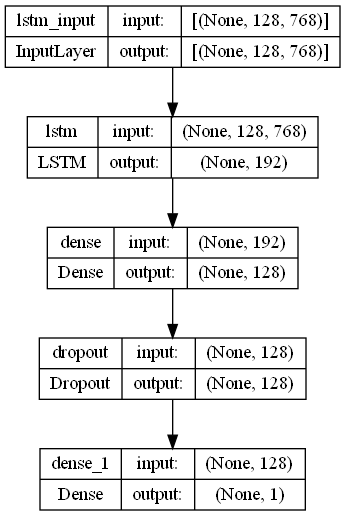

In [18]:
from keras.utils import plot_model

plot_model(best_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [7]:
from sklearn.metrics import classification_report

target_names = label_encoder.classes_
report = classification_report(test_labels, test_predictions, target_names=target_names)
print(report)

              precision    recall  f1-score   support

    negative       0.85      0.97      0.91       180
    positive       0.97      0.85      0.91       203

    accuracy                           0.91       383
   macro avg       0.91      0.91      0.91       383
weighted avg       0.91      0.91      0.91       383



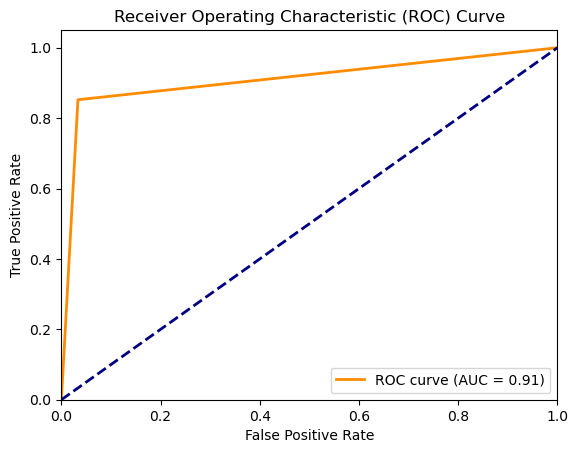

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Books dataset

In [9]:
data1 = []
for domain in ['books'] :
  path = "../Downloads/215 Projects/unprocessed.tar/sorted_data/sorted_data/books/negative.review"
  #path = "negative.review"
  tree = ET.parse(path)
  root = tree.getroot()
  for review in root:
    review_dict = {}
    for elem in review:
        if elem.tag in ['review_text', 'rating']:
            review_dict[elem.tag] = elem.text.strip()
        review_dict["polarity"] = "negative"
    data1.append(review_dict)

for domain in ['books'] :
  path = "../Downloads/215 Projects/unprocessed.tar/sorted_data/sorted_data/books/positive.review"
  #path = "positive.review"
  tree = ET.parse(path)
  root = tree.getroot()
  for review in root:
    review_dict = {}
    for elem in review:
        if elem.tag in ['review_text', 'rating']:
            review_dict[elem.tag] = elem.text.strip()
        review_dict["polarity"] = "positive"
    data1.append(review_dict)

In [10]:
# Loading the pre-trained GPT model and tokenizer
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, TFAutoModel
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import kerastuner as kt

model_name = "distilgpt2"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model_token = transformers.TFAutoModel.from_pretrained(model_name)

# Define the maximum sequence length and batch size
max_length = 128
batch_size = 8

tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

from sklearn.model_selection import train_test_split

# Split the data into train and test sets
reviews1 = [d["review_text"] for d in data1]
labels1 = [d["polarity"] for d in data1]
train_reviews1, test_reviews1, train_labels1, test_labels1 = train_test_split(reviews1, labels1, test_size=0.2, random_state=42)

# Tokenize the review texts using the tokenizer
encoded_train_reviews1 = tokenizer(train_reviews1, padding=True, truncation=True, max_length=max_length, return_tensors="tf")
encoded_test_reviews1 = tokenizer(test_reviews1, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

# Generate embeddings for the reviews using the GPT model
train_embeddings1 = model_token(encoded_train_reviews1.input_ids, attention_mask=encoded_train_reviews1.attention_mask)[0]
test_embeddings1 = model_token(encoded_test_reviews1.input_ids, attention_mask=encoded_test_reviews1.attention_mask)[0]

# Convert the labels to numerical values using LabelEncoder
label_encoder1 = LabelEncoder()
train_labels1 = label_encoder.fit_transform(train_labels1)
test_labels1 = label_encoder.transform(test_labels1)


def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64), input_shape=(max_length, 768)))
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='binary_crossentropy', metrics=['accuracy'])
    return model


All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [11]:
#Using Keras Tuner
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=100, factor=3, directory='my_dir', project_name='my_project')
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, save_weights_only=False, monitor="val_accuracy", mode="max")
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, mode="max", restore_best_weights=True)


tuner.search(train_embeddings1, train_labels1, validation_split=0.2, batch_size=batch_size, callbacks=[checkpoint, early_stopping])


best_model1 = tuner.get_best_models(num_models=1)[0]
test_predictions1 = best_model.predict(test_embeddings1)
test_predictions1 = np.round(test_predictions1).flatten()
test_accuracy1 = accuracy_score(test_labels1, test_predictions1)
test_precision1 = precision_score(test_labels1, test_predictions1)
test_recall1 = recall_score(test_labels1, test_predictions1)
test_f1_score1 = f1_score(test_labels1, test_predictions1)
print("Accuracy:", test_accuracy1)
print("Precision:", test_precision1)
print("Recall:", test_recall1)
print("F1 Score:", test_f1_score1)

INFO:tensorflow:Reloading Tuner from my_dir\my_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
13/13 [==============================] - 2s 117ms/step
Accuracy: 0.9025
Precision: 0.875
Recall: 0.9402985074626866
F1 Score: 0.9064748201438849


In [12]:
from sklearn.metrics import classification_report

target_names1 = label_encoder.classes_
report1 = classification_report(test_labels1, test_predictions1, target_names=target_names1)
print(report1)

              precision    recall  f1-score   support

    negative       0.93      0.86      0.90       199
    positive       0.88      0.94      0.91       201

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



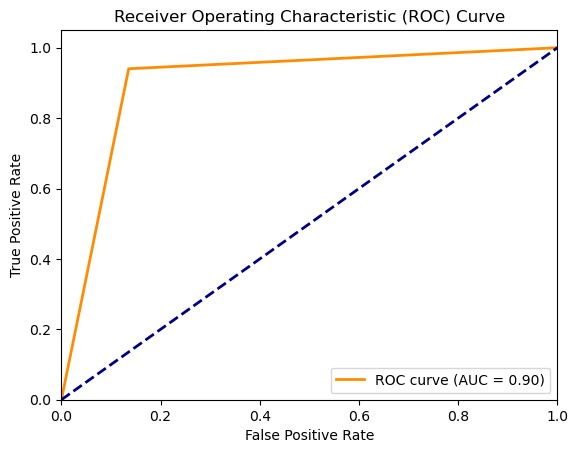

In [13]:
fpr1, tpr1, thresholds1 = roc_curve(test_labels1, test_predictions1)
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"- Units: {best_hyperparameters.get('units')}")
print(f"- Dropout: {best_hyperparameters.get('dropout')}")
print(f"- Learning rate: {best_hyperparameters.get('learning_rate')}")


Best hyperparameters:
- Units: 128
- Dropout: 0.1
- Learning rate: 0.0001
